In [10]:
# importing necessary libraries and functions needed
import pandas as pd 
import numpy as np
from IPython.display import display # for displaying in tabular format
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Data Summary
Below is the summary of the dataset being used, such as the data in the first couple of the initial and last rows, information about the dataset, count of non-spam and spam emails, and statistics. 

In [7]:
# read the combined data set (data2 + data3) that has dropped NULL values
data = pd.read_csv("combined_data_clean.csv")

# displaying the initial and last 5 rows
display(data.head(), data.tail())

,label,email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


,label,email
8024,1,abc s good morning america ranks it the NUMBE...
8025,1,hyperlink hyperlink hyperlink let mortgage le...
8026,1,thank you for shopping with us gifts for all ...
8027,1,the famous ebay marketing e course learn to s...
8028,1,hello this is chinese traditional 子 件 NUMBER世...


In [8]:
# more information about the dataset that we are using
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8029 entries, 0 to 8028
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8029 non-null   int64 
 1   email   8029 non-null   object
dtypes: int64(1), object(1)
memory usage: 125.6+ KB


In [9]:
# how many spam and NOT spam emails we have
# NOTE: 0 = NOT SPAM | 1 = SPAM
print(data['label'].value_counts())

label
0    6961
1    1068
Name: count, dtype: int64


In [10]:
# general stats of dataset
data.describe()

,label
count,8029.000000
mean,0.133018
std,0.339615
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Visualization Analysis
Below are some visualizations of the data. 
This is so that we can visually understand the dataset and can provide an analysis on it.

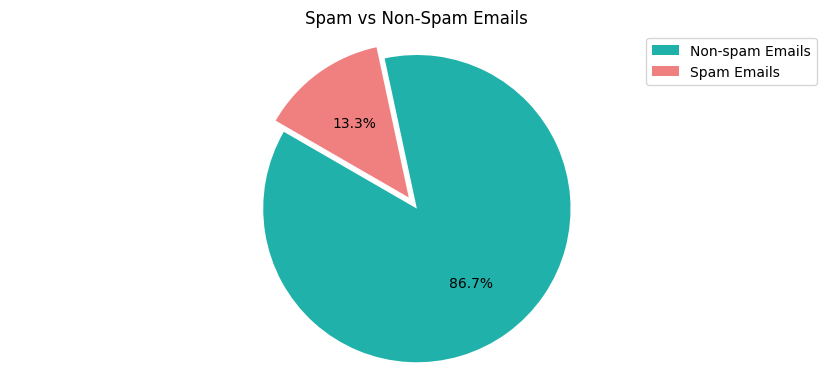

In [11]:
# pie chart visual
# will show how many spam and non-spam emails there are in the dataset
not_spam = data[data['label'] == 0]['email'].count()
spam = data[data['label'] == 1]['email'].count()

# plotting chart
# labels = ['Non-spam Emails', 'Spam Emails']
sizes = [not_spam, spam]
colors = ['#20B2AA', '#F08080']
explode = (0.09, 0) 

plt.figure(figsize=(10.5, 4.5))
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=150)
plt.title('Spam vs Non-Spam Emails')
plt.axis('equal')
plt.legend(loc="upper right", labels=['Non-spam Emails', 'Spam Emails'])

plt.show()

There are more non-spam emails in this dataset, but there is still a handful of spam emails.

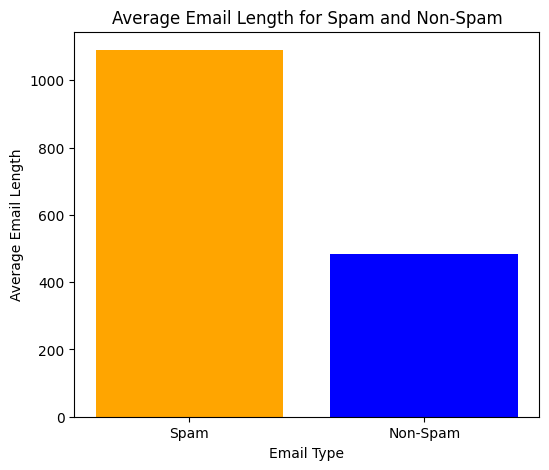

In [12]:
# bar chart visual 
# this will display the average long the spam and non-spam emails are
# to see if there is a pattern in length for both categories

# average length for spam and not spam emails
spam_length = data[data['label'] == 1]['email'].apply(len).mean()
not_spam_length = data[data['label'] == 0]['email'].apply(len).mean()

# creating the bar chart 
plt.figure(figsize=(6, 5))
plt.bar(['Spam', 'Non-Spam'], [spam_length, not_spam_length], color=['orange', 'blue'])
plt.xlabel('Email Type')
plt.ylabel('Average Email Length')
plt.title('Average Email Length for Spam and Non-Spam')

plt.show()

The average length of spam emails were longer than non-spam emails.

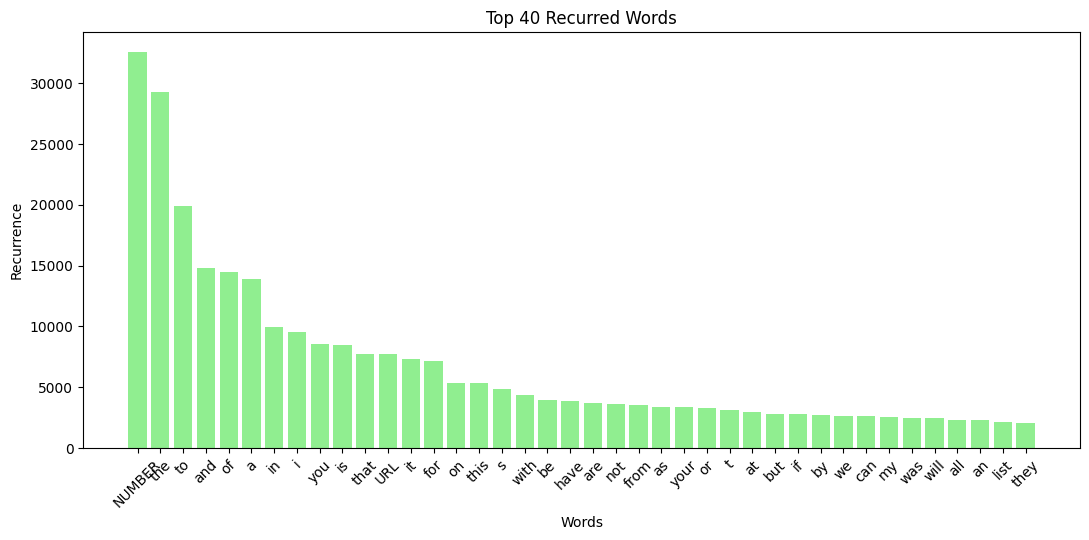

In [13]:
# bar chart visual to essentially show what word count had showed
# however, this will give me the number of recurrence of a word in both emails

# put spam and non-spam emails together into 1
emails = ' '.join(data['email'])

# get the indiviual words from the email
# and count each words
words = emails.split()
count = Counter(words)

# recurrence of top 40 words in the email
top_common = dict(count.most_common(40))

# plotting
plt.figure(figsize=(11, 5.5))
plt.bar(top_common.keys(), top_common.values(), color='#90EE90')
plt.title('Top 40 Recurred Words')
plt.xlabel('Words')
plt.ylabel('Recurrence')
plt.xticks(rotation = 45) 
plt.tight_layout()

plt.show()

A lot of the frequent words in both type of emails are common words. This may be removed to refine the data for modeling and analysis.

## Preprocessing Data
Preparing the data in the set for modeling.
1. lowercase the text so that it is the same throughout
2. breaking down the words in the emails
3. removing common words 

In [14]:
# downloading necessary libraries from nltk on here
import nltk
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/emilykim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilykim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

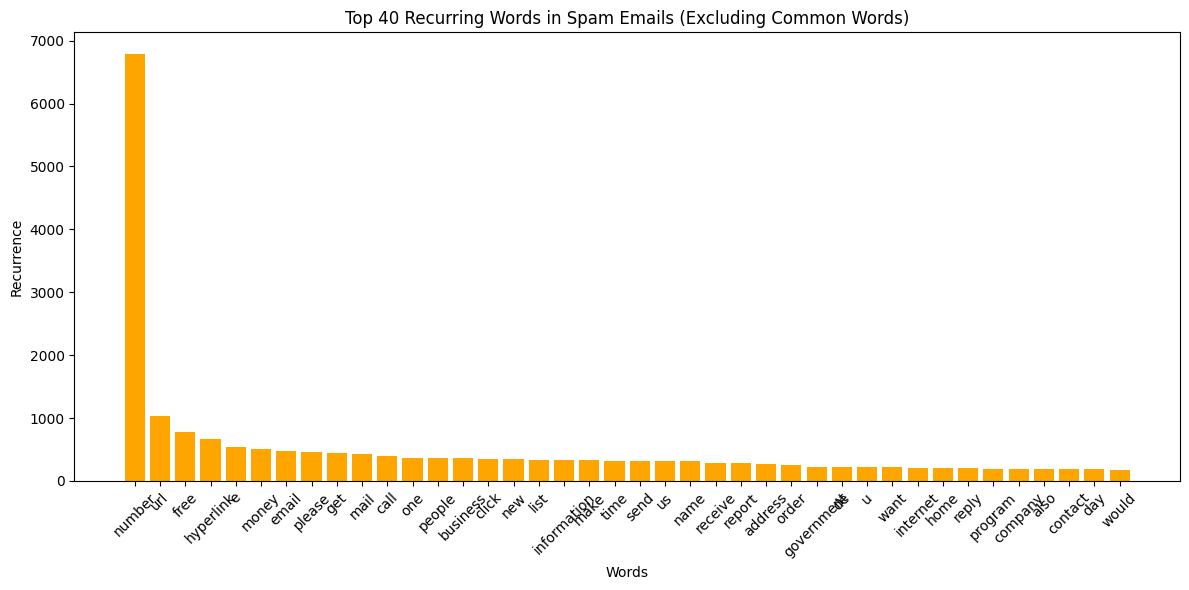

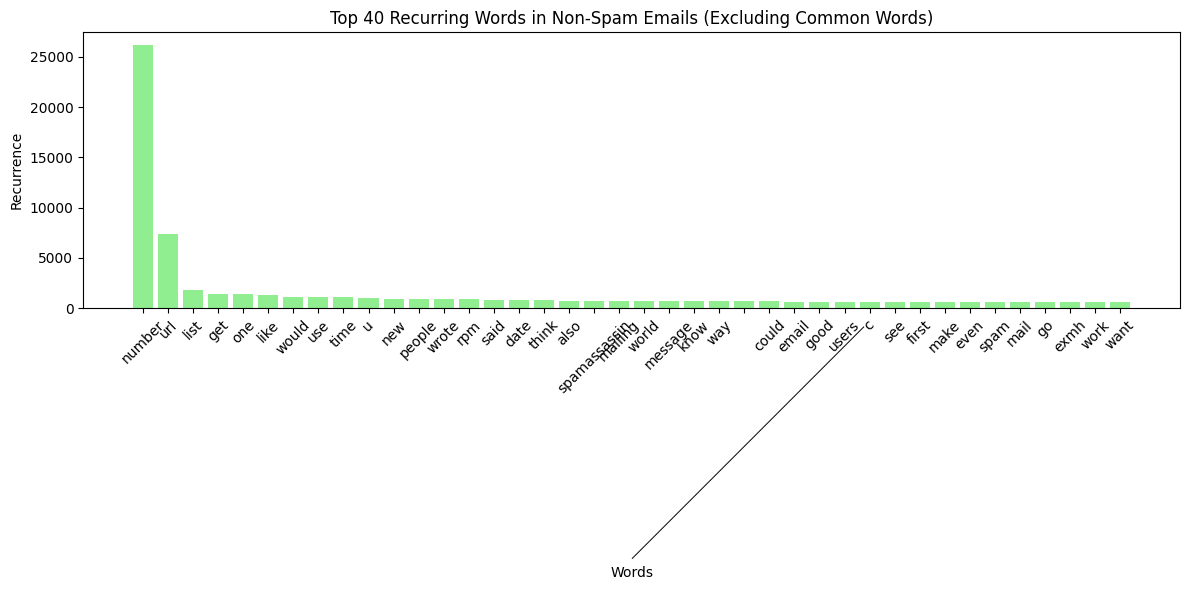

In [15]:
# libraries and function used are put here for now
# bar chart visual to essentially show what word count had showed
# however, this will give me the number of recurrence of a word for the emails individually
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

spam_emails = data[data['label'] == 1]['email'].tolist()
not_spam_emails = data[data['label'] == 0]['email'].tolist()

stopwords = set(stopwords.words('english'))

# filter out the common words(stopwords)
def preprocess_and_filter(emails):
    words = ' '.join(emails).split()
    return [word.lower() for word in words if word.lower() not in stopwords]

# filter out the stopwords in each of the types of email
filtered_spam = preprocess_and_filter(spam_emails)
filtered_not_spam = preprocess_and_filter(not_spam_emails)

# count both emails
spam_counts = Counter(filtered_spam)
not_spam_counts = Counter(filtered_not_spam)

# show top 40 
top_spam = dict(spam_counts.most_common(40))
top_not_spam = dict(not_spam_counts.most_common(40))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_spam.keys(), top_spam.values(), color='orange')
plt.title('Top 40 Recurring Words in Spam Emails (Excluding Common Words)')
plt.xlabel('Words')
plt.ylabel('Recurrence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting word frequency distribution for top N recurring words in non-spam emails
plt.figure(figsize=(12, 6))
plt.bar(top_not_spam.keys(), top_not_spam.values(), color='#90EE90')
plt.title('Top 40 Recurring Words in Non-Spam Emails (Excluding Common Words)')
plt.xlabel('Words')
plt.ylabel('Recurrence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# create function that preprocesses the data
def preprocess_text(text):
    # handles 1.
    text = text.lower()
    
    # handles 2.
    tokens = word_tokenize(text)
    
    # handle 3.
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    
    return filtered_tokens

# adding new column to .csv dataset with processed data
data['processed_email'] = data['email'].apply(preprocess_text)

print(data['processed_email'].head())

0    [go, jurong, point, crazy, .., available, bugi...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3    [u, dun, say, early, hor, ..., u, c, already, ...
4    [nah, n't, think, goes, usf, lives, around, th...
Name: processed_email, dtype: object


In [21]:
data.head()

,label,email,processed_email
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, .., available, bugi..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, n't, think, goes, usf, lives, around, th..."


In [18]:
# drop grammar error count column -> this was before (I had accidentally made) 
#data.drop(columns='grammar_errors_count', inplace=True)

In [20]:
# SVM model on the preprocessed data from above

# need to convert into string -> error occurred when running
data['processed_email'] = data['processed_email'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# split data and test
X_train, X_test, y_train, y_test = train_test_split(data['processed_email'], data['label'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# create svm model
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)
predictions = model.predict(X_test_tfidf)

# evaluate the model's accuracy in a report style/format
print("SVM Model")
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

SVM Model
Accuracy: 0.9782067247820673
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1376
           1       0.98      0.87      0.92       230

    accuracy                           0.98      1606
   macro avg       0.98      0.93      0.95      1606
weighted avg       0.98      0.98      0.98      1606



In [19]:
# Logistic Regression model on the preprocessed data 

# need to convert this to string -> error had occurred
data['processed_email'] = data['processed_email'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

# split data and test
X_train, X_test, y_train, y_test = train_test_split(data['processed_email'], data['label'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# creating Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
predictions = model.predict(X_test_tfidf)

# evaluate the model's accuracy in a report style/format
print("Logistic Regression Model")
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Logistic Regression Model
Accuracy: 0.9526774595267746
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1376
           1       0.97      0.69      0.81       230

    accuracy                           0.95      1606
   macro avg       0.96      0.84      0.89      1606
weighted avg       0.95      0.95      0.95      1606

